**EDA**

In [ ]:
ls = [
    "Flask",
    "werkzeug",
    "numpy",
    "Pillow",
    "scikit-learn",
    "joblib",
    "opencv-python",
    "scikit-image",
    "matplotlib",
    "seaborn",
    "gdown",
    "xgboost",
    "optuna"
]

for i in ls:
    !pip install $i


In [ ]:
import gdown

# Link to the dataset
url = 'https://drive.google.com/uc?export=download&id=1lWgKokYUrD5PPMO3tCy-yMN2ytaSnjTV'

# Download the dataset
output = 'dataset.zip'
gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1lWgKokYUrD5PPMO3tCy-yMN2ytaSnjTV
From (redirected): https://drive.google.com/uc?export=download&id=1lWgKokYUrD5PPMO3tCy-yMN2ytaSnjTV&confirm=t&uuid=54ecaa1e-8153-4745-9cad-7f50faca691f
To: /content/dataset.zip
100%|██████████| 94.9M/94.9M [00:05<00:00, 17.2MB/s]


'dataset.zip'

In [ ]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')


In [ ]:
import os
print(os.listdir('dataset/dataset_full'))

['Streets', 'Forest', 'Sea', 'Glacier', 'Building', 'Mountains']


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops
import shutil
import pandas as pd
from sklearn.decomposition import PCA

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

def load_dataset(data_dir):
    image_paths = []
    labels = []
    class_names = []

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_names.append(class_name)
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    img_path = os.path.join(class_path, img_name)
                    image_paths.append(img_path)
                    labels.append(class_names.index(class_name))

    return image_paths, labels, class_names

# Load the dataset
data_dir = 'dataset/dataset_full'
image_paths, labels, class_names = load_dataset(data_dir)

print(f"Total number of images: {len(image_paths)}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")


Total number of images: 5245
Number of classes: 6
Class names: ['Streets', 'Forest', 'Sea', 'Glacier', 'Building', 'Mountains']


Class Streets: 500 images
Class Forest: 2745 images
Class Sea: 500 images
Class Glacier: 500 images
Class Building: 500 images
Class Mountains: 500 images


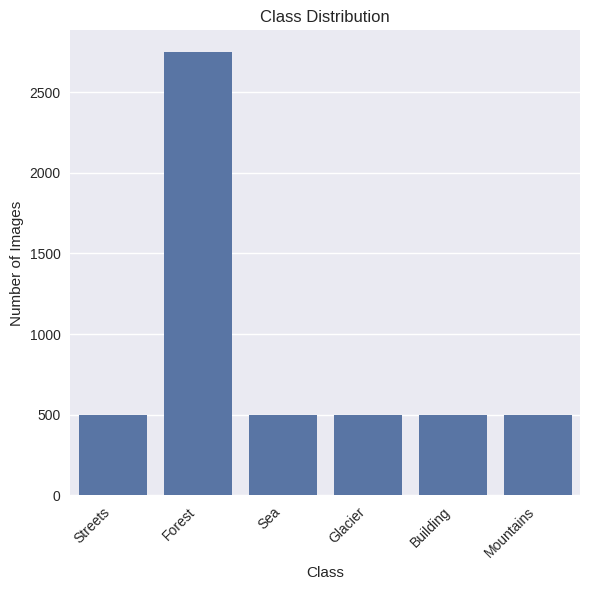

In [ ]:
# Class Distribution
def plot_class_distribution(labels, class_names):
    class_counts = Counter(labels)

    # Print number of images in each class
    for i, class_name in enumerate(class_names):
        print(f'Class {class_name}: {class_counts[i]} images')

    # Plotting the class distribution
    plt.figure(figsize=(6, 6))
    sns.barplot(x=class_names, y=[class_counts[i] for i in range(len(class_names))])
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Assuming you have the 'labels' and 'class_names' variables defined
plot_class_distribution(labels, class_names)


Analyzing dimensions: 100%|██████████| 5245/5245 [00:16<00:00, 323.36it/s]


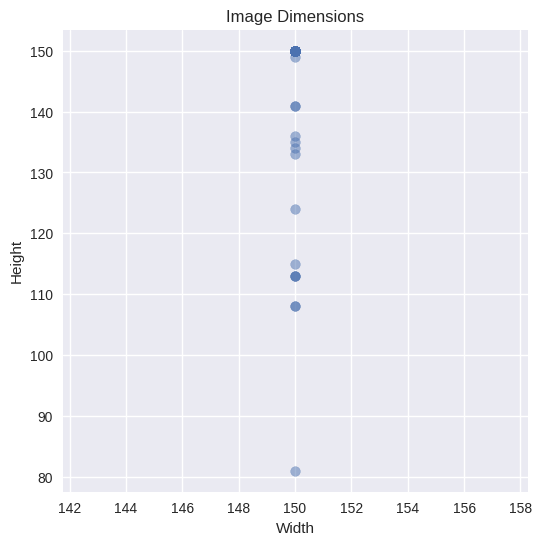

Number of valid images: 5245
Number of invalid images: 0
Unique dimensions: {(124, 150), (115, 150), (134, 150), (113, 150), (108, 150), (149, 150), (133, 150), (150, 150), (135, 150), (81, 150), (141, 150), (136, 150)}
Most common dimensions: ((150, 150), 5230)


In [ ]:
# image dimension analysis
def analyze_image_dimensions(directory):
    image_paths,_,_ = load_dataset(directory)
    dimensions = []
    invalid_images = []

    for path in tqdm(image_paths, desc="Analyzing dimensions"):
        try:
            img = cv2.imread(path)
            if img is not None:
                dimensions.append(img.shape[:2])
            else:
                invalid_images.append(path)
        except Exception as e:
            print(f"Error processing {path}: {str(e)}")
            invalid_images.append(path)

    unique_dimensions = set(dimensions)

    if dimensions:
        heights, widths = zip(*dimensions)
        plt.figure(figsize=(6, 6))
        plt.scatter(widths, heights, alpha=0.5)
        plt.title('Image Dimensions')
        plt.xlabel('Width')
        plt.ylabel('Height')
        plt.show()

        print(f"Number of valid images: {len(dimensions)}")
        print(f"Number of invalid images: {len(invalid_images)}")
        print(f"Unique dimensions: {unique_dimensions}")
        print(f"Most common dimensions: {Counter(dimensions).most_common(1)[0]}")
    else:
        print("No valid images found.")

    return invalid_images, unique_dimensions

invalid_images, unique_dimensions = analyze_image_dimensions(data_dir)


Analyzing colors: 100%|██████████| 1000/1000 [00:05<00:00, 173.51it/s]


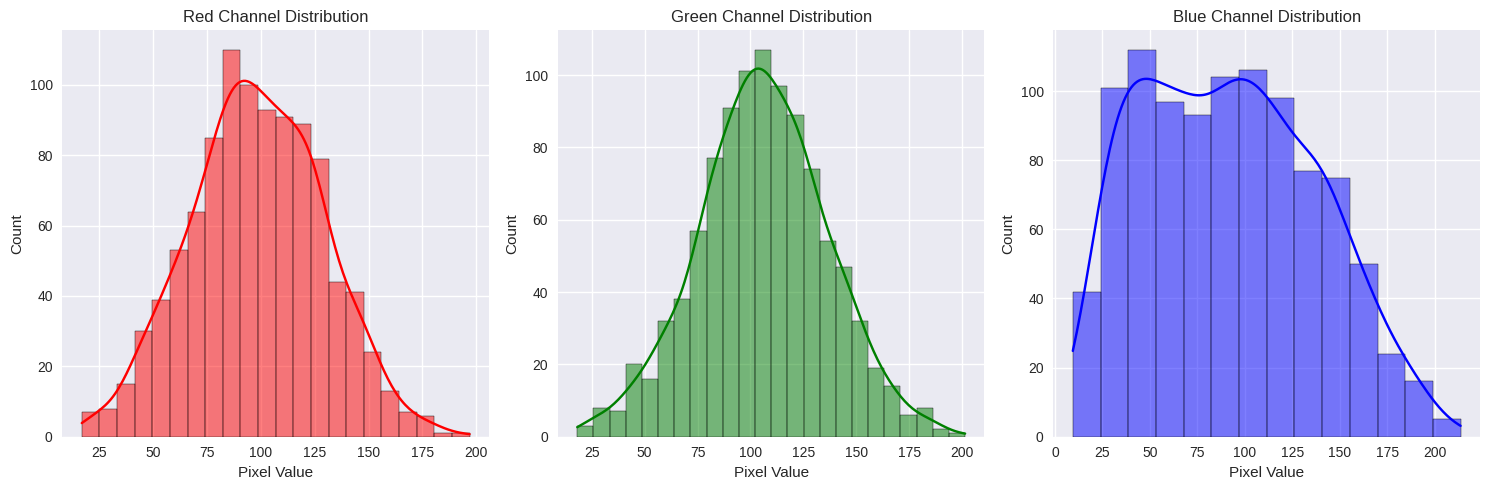

In [ ]:
def analyze_color_distribution(directory, num_samples=1000):
    if num_samples > len(image_paths):
        print(f"Number of samples requested ({num_samples}) exceeds the number of available images ({len(image_paths)}). Using {len(image_paths)} samples.")
        num_samples = len(image_paths)

    sampled_paths = np.random.choice(image_paths, num_samples, replace=False)
    color_means = []

    for path in tqdm(sampled_paths, desc="Analyzing colors"):
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mean_color = np.mean(img, axis=(0, 1))
            color_means.append(mean_color)
        else:
            print(f"Failed to read image: {path}")

    color_means = np.array(color_means)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    channels = ['Red', 'Green', 'Blue']

    for i in range(3):
        sns.histplot(color_means[:, i], kde=True, color=channels[i].lower(), ax=axs[i])
        axs[i].set_title(f'{channels[i]} Channel Distribution')
        axs[i].set_xlabel('Pixel Value')

    plt.tight_layout()
    plt.show()

    return color_means

color_means = analyze_color_distribution(data_dir)


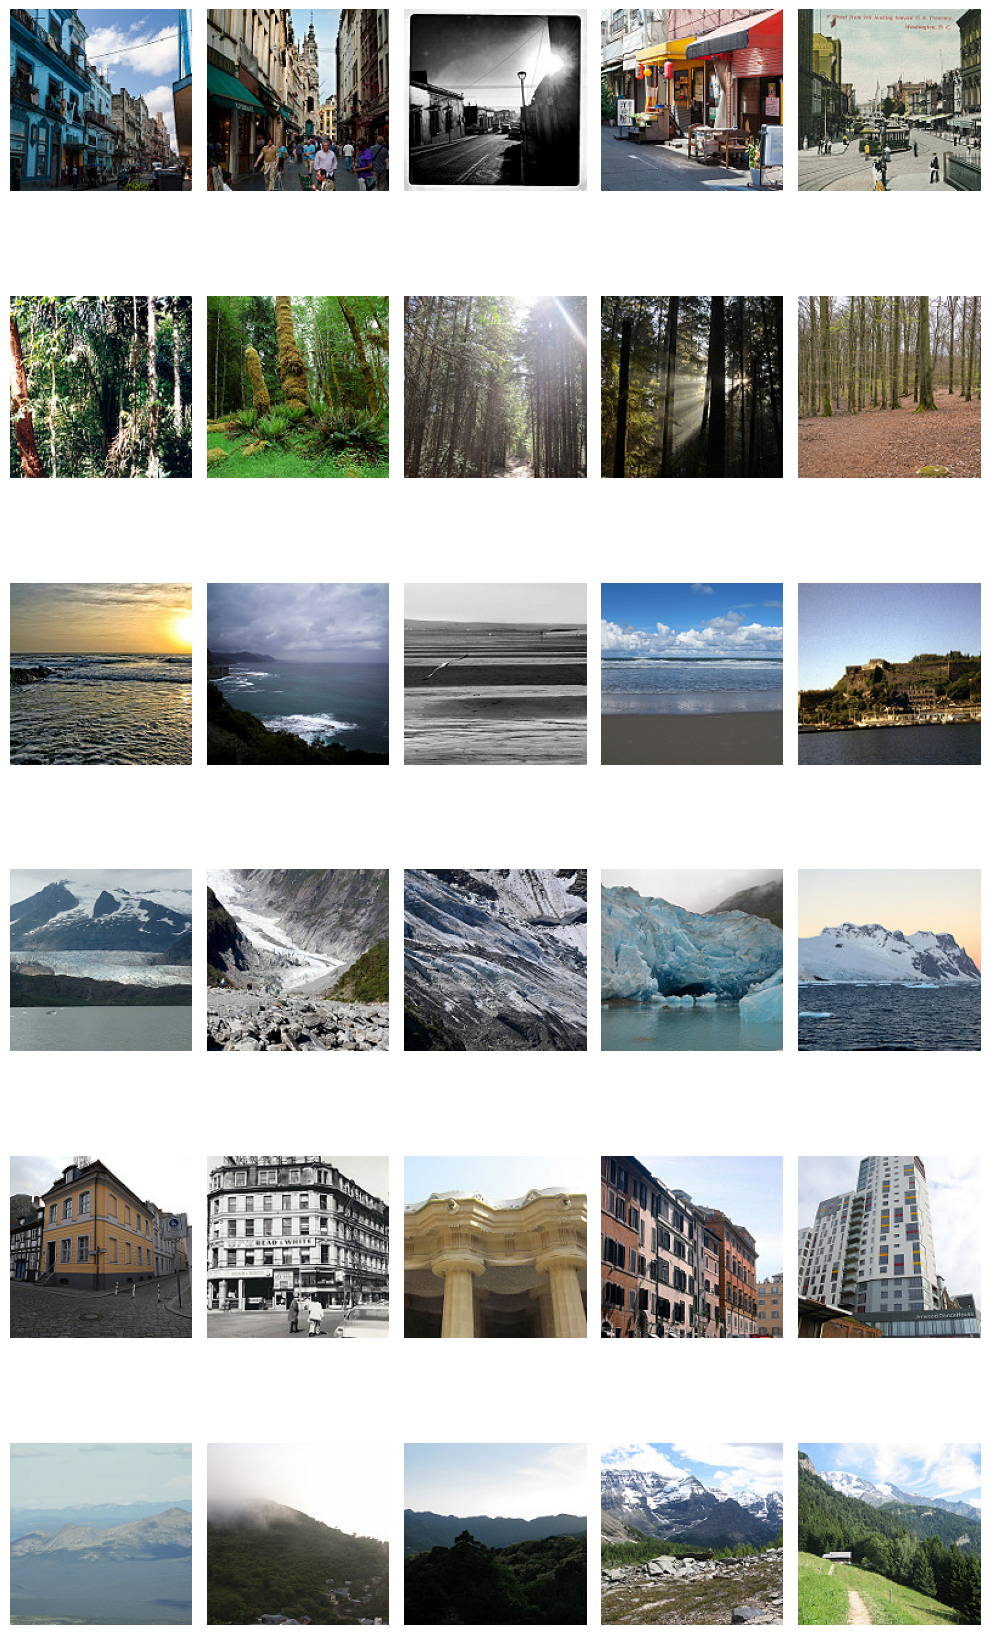

In [ ]:
def plot_sample_images(image_paths, labels, class_names, samples_per_class=5):
    num_classes = len(class_names)
    fig, axs = plt.subplots(num_classes, samples_per_class, figsize=(10, 3*num_classes))

    for i, class_name in enumerate(class_names):
        class_images = [path for path, label in zip(image_paths, labels) if label == i]

        if len(class_images) < samples_per_class:
            print(f"Not enough images for class {class_name}. Requested {samples_per_class}, but only {len(class_images)} available.")
            sampled_images = class_images
        else:
            sampled_images = np.random.choice(class_images, samples_per_class, replace=False)

        for j, img_path in enumerate(sampled_images):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axs[i, j].imshow(img)
                axs[i, j].axis('off')

                if j == 0:
                    axs[i, j].set_ylabel(class_name, rotation=90, labelpad=20)
            else:
                print(f"Error loading image: {img_path}")

    plt.tight_layout()
    plt.show()

# Plot sample images
plot_sample_images(image_paths, labels, class_names)


Analyzing image quality: 100%|██████████| 1000/1000 [00:04<00:00, 202.86it/s]


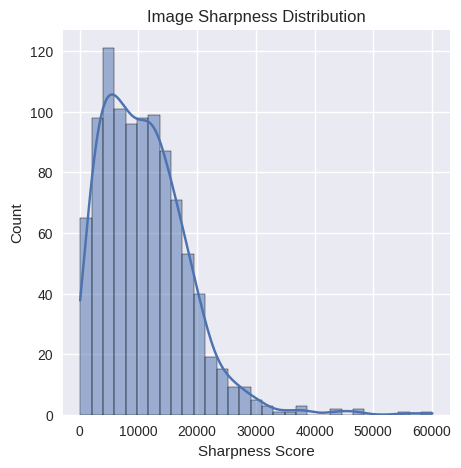

Min sharpness: 99.63
Max sharpness: 60072.73
Mean sharpness: 11043.06
Median sharpness: 10220.15


In [ ]:
# Image Quality Analysis
def analyze_image_quality(image_paths, num_samples=1000):
    sampled_paths = np.random.choice(image_paths, num_samples, replace=False)
    sharpness_scores = []

    for path in tqdm(sampled_paths, desc="Analyzing image quality"):
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
        sharpness_scores.append(sharpness)

    plt.figure(figsize=(5, 5))
    sns.histplot(sharpness_scores, kde=True)
    plt.title('Image Sharpness Distribution')
    plt.xlabel('Sharpness Score')
    plt.show()

    print(f"Min sharpness: {min(sharpness_scores):.2f}")
    print(f"Max sharpness: {max(sharpness_scores):.2f}")
    print(f"Mean sharpness: {np.mean(sharpness_scores):.2f}")
    print(f"Median sharpness: {np.median(sharpness_scores):.2f}")

    return sharpness_scores

sharpness_scores = analyze_image_quality(image_paths)


Analyzing texture: 100%|██████████| 1000/1000 [00:11<00:00, 85.65it/s]


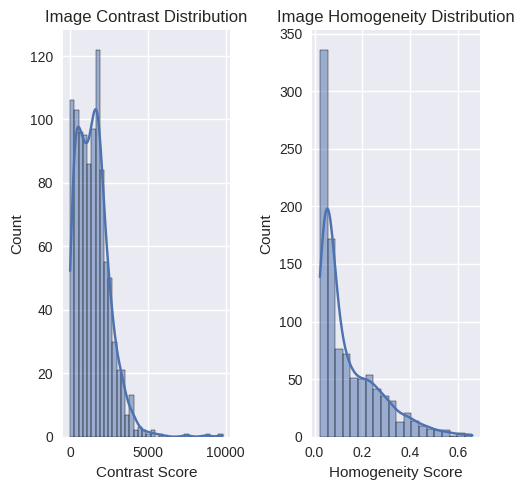

In [ ]:
# Texture Analysis
def analyze_texture(image_paths, num_samples=1000):
    sampled_paths = np.random.choice(image_paths, num_samples, replace=False)
    contrast_scores = []
    homogeneity_scores = []

    for path in tqdm(sampled_paths, desc="Analyzing texture"):
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        glcm = graycomatrix(gray, [1], [0], 256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        contrast_scores.append(contrast)
        homogeneity_scores.append(homogeneity)

    plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(contrast_scores, kde=True)
    plt.title('Image Contrast Distribution')
    plt.xlabel('Contrast Score')

    plt.subplot(1, 2, 2)
    sns.histplot(homogeneity_scores, kde=True)
    plt.title('Image Homogeneity Distribution')
    plt.xlabel('Homogeneity Score')

    plt.tight_layout()
    plt.show()

    return contrast_scores, homogeneity_scores

contrast_scores, homogeneity_scores = analyze_texture(image_paths)


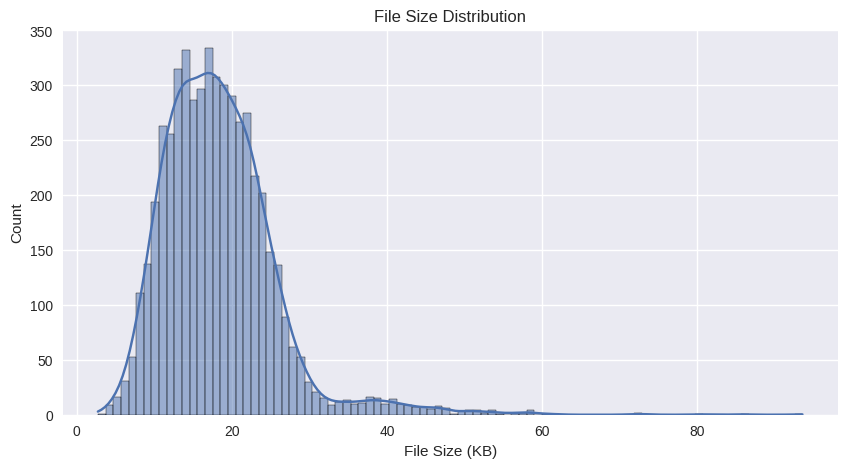

Min file size: 2.71 KB
Max file size: 93.53 KB
Mean file size: 18.32 KB
Median file size: 17.49 KB


In [ ]:
# File Size Analysis
def analyze_file_sizes(image_paths):
    file_sizes = [os.path.getsize(path) / 1024 for path in image_paths]  # Convert to KB

    plt.figure(figsize=(10, 5))
    sns.histplot(file_sizes, kde=True)
    plt.title('File Size Distribution')
    plt.xlabel('File Size (KB)')
    plt.show()

    print(f"Min file size: {min(file_sizes):.2f} KB")
    print(f"Max file size: {max(file_sizes):.2f} KB")
    print(f"Mean file size: {np.mean(file_sizes):.2f} KB")
    print(f"Median file size: {np.median(file_sizes):.2f} KB")

    return file_sizes

file_sizes = analyze_file_sizes(image_paths)

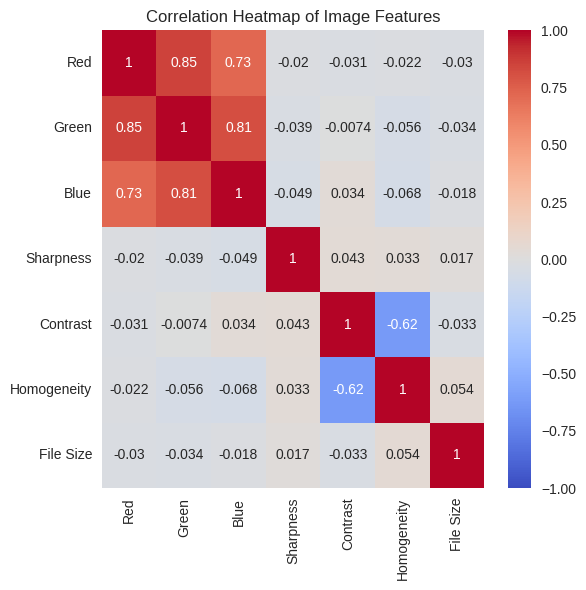

In [ ]:
# Correlation Analysis
def correlation_analysis(color_means, sharpness_scores, contrast_scores, homogeneity_scores, file_sizes):
    data = {
        'Red': color_means[:, 0],
        'Green': color_means[:, 1],
        'Blue': color_means[:, 2],
        'Sharpness': sharpness_scores,
        'Contrast': contrast_scores,
        'Homogeneity': homogeneity_scores,
        'File Size': file_sizes[:len(color_means)]
    }
    df = pd.DataFrame(data)

    plt.figure(figsize=(6, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap of Image Features')
    plt.tight_layout()
    plt.show()

correlation_analysis(color_means, sharpness_scores, contrast_scores, homogeneity_scores, file_sizes)


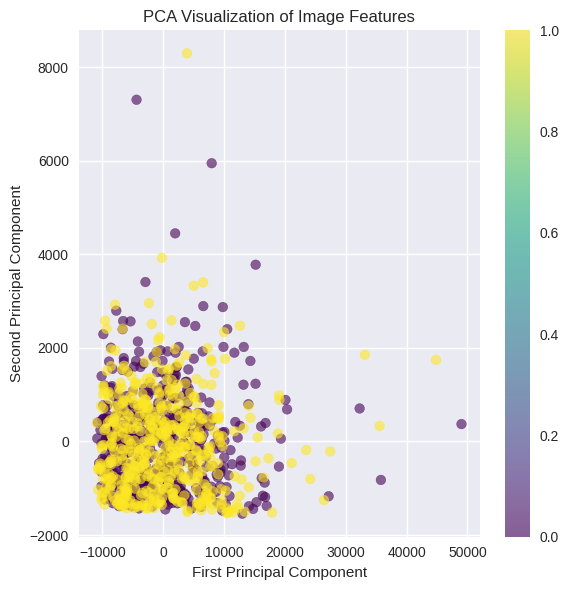

Explained variance ratio: [0.97986271 0.02006733]


In [ ]:
#PCA Visualization
def pca_visualization(color_means, sharpness_scores, contrast_scores, homogeneity_scores, labels):
    features = np.column_stack((color_means, sharpness_scores, contrast_scores, homogeneity_scores))
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('PCA Visualization of Image Features')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.tight_layout()
    plt.show()
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

pca_visualization(color_means, sharpness_scores, contrast_scores, homogeneity_scores, labels[:len(color_means)])


**Summary of the key findings:**

1. Dataset Overview:
- The dataset consists of 5,245 images across 6 classes: Sea, Mountains, Building, Forest, Glacier, and Streets.

2. Class Distribution:
- The dataset is imbalanced, with the Forest class having significantly more images (2,745) compared to the other classes, which have 500 images each.

3. Image Dimensions:
- Almost all images have a consistent dimension of (150, 150) pixels, with only a few outliers. There are no invalid images in the dataset.

4. Color Distribution:
- The color distributions for the red, green, and blue channels appear to be relatively normal, with peaks in the middle range. This suggests that color features could be informative for classification.

5. Image Quality (Sharpness):
- The sharpness scores of the images vary widely, ranging from a minimum of 99.63 to a maximum of 60072.73. The mean sharpness is 11043.06, and the median is 10220.15. This indicates varying image qualities within the dataset.

6. Texture Analysis:
- The contrast and homogeneity distributions were analyzed, showing the spread of these texture features across the dataset. The variability in these features might be helpful for distinguishing between classes.

7. File Size Analysis:
- The file sizes of the images vary considerably, with a minimum of 2.71 KB and a maximum of 93.53 KB. However, most images are relatively small, with a mean file size of 18.32 KB and a median of 17.49 KB.

8. Correlation Analysis:
- A heatmap was generated to visualize the correlations between different image features, including color channels, sharpness, contrast, homogeneity, and file size. This can help identify relationships and potential redundancies among the features.

9. PCA Visualization:
- A 2D visualization of the image features was created using Principal Component Analysis (PCA). This can provide insights into any clustering or patterns in the dataset based on the extracted features.

Key Insights:
1. The class imbalance in the dataset needs to be considered and potentially addressed during modeling.
2. The consistency in image dimensions is a positive aspect, but the few outliers may require attention during preprocessing.
3. The wide range of image qualities and file sizes suggests that preprocessing techniques like normalization or resizing might be beneficial.
4. The color distributions indicate that color features could be valuable for classification tasks.
5. The variability in texture features (contrast and homogeneity) could aid in differentiating between classes.
